<a href="https://colab.research.google.com/github/manas0/salt-and-pepper-noise-removal/blob/main/SAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Median Filter**

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving image057.png to image057.png
Saving lena_512.png to lena_512.png
User uploaded file "image057.png" with length 243166 bytes
User uploaded file "lena_512.png" with length 129973 bytes


In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow
img = cv.imread('image057.png', cv.IMREAD_GRAYSCALE)
original = cv.imread('lena_512.png', cv.IMREAD_GRAYSCALE)

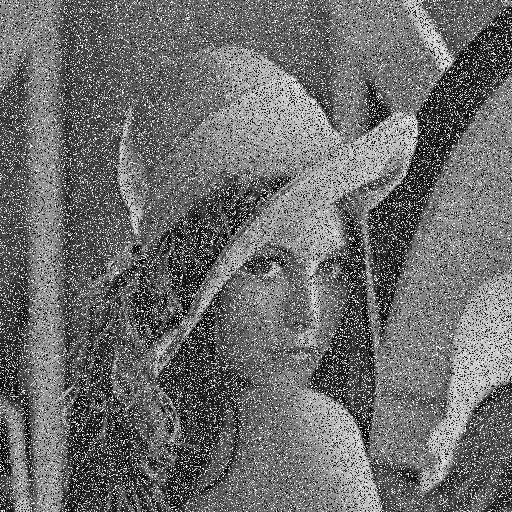

In [ ]:
import matplotlib.pyplot as plt

cv2_imshow(img)

In [ ]:
import numpy as np

def med_filter(img, kernel_size):
  x = int(kernel_size/2)

  result = np.zeros((img.shape[0], img.shape[1]))

  img = np.pad(img, x)

  for i in range(result.shape[0]):
    for j in range(result.shape[1]):
      result[i][j] = np.median(img[i:i+x+x+1, j:j+x+x+1])

  return result

In [ ]:
med_img13 = med_filter(img, 3)
cv2_imshow(med_img13)

In [ ]:
med_img15 = med_filter(img, 5)
cv2_imshow(med_img15)

In [ ]:
med_img17 = med_filter(img, 9)
cv2_imshow(med_img17)

In [ ]:
import numpy
import math
def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
    	return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

**Adaptive Median Filter**

In [ ]:
def Adaptive_med_filter(pic, maxi):
  x_max = int(maxi/2)
  
  result = np.zeros((pic.shape[0], pic.shape[1]))

  pic = np.pad(pic, x_max)

  for i in range(result.shape[0]):
    for j in range(result.shape[1]):
      
      flag = 0
      for q in range(1, x_max+1):
        temp = pic[i+x_max-q:i+x_max+q+1, j+x_max-q:j+x_max+q+1]
        maxi = temp.max()
        mini = temp.min()
        med = np.median(temp)
        if(med > mini and med < maxi):
          if(pic[i+x_max][j+x_max] > mini and pic[i+x_max][j+x_max] < maxi):
            result[i][j] = pic[i+x_max][j+x_max]
            flag = 1
            break
          else:
            result[i][j] = med
            flag = 1
            break

      if(flag == 0):
        result[i][j] = med
  return result

In [ ]:
med_img = Adaptive_med_filter(img, 25)

#f = plt.figure()
#f.add_subplot(1,2, 1)
#plt.imshow(img, cmap='gray')
#f.add_subplot(1,2, 2)
cv2_imshow(med_img)
#plt.show(block=True)

In [ ]:
print('PSNR between original and noisy image = ',psnr(original,img))
print('PSNR between med_img and noisy image = ',psnr(med_img13,original))
print('PSNR between med_img and noisy image = ',psnr(med_img15,original))
print('PSNR between med_img and noisy image = ',psnr(med_img17,original))
print('PSNR between med_img and original image = ',psnr(med_img,original))

PSNR between original and noisy image =  31.886679285122284
PSNR between med_img and noisy image =  23.388355001662283
PSNR between med_img and noisy image =  27.23943304457847
PSNR between med_img and noisy image =  25.092260862533404
PSNR between med_img and original image =  16.400467004049577


**Variational Method for Impulse Noise Cleaning**

In [ ]:
def signum(x):
  if(x == 0):
    return 0

  if(x>0):
    return 1

  return -1

def psi(x,alpha):
  return abs(x)**alpha


def psi_(x,alpha):
  return signum(x)*alpha*(abs(x)**(alpha-1))


In [ ]:
def H(z,alpha,beta,d,sign):
  x = 0
  for i in d:
    x += psi_(z-i,alpha)

  x = x*beta
  x = x - sign 
  return x

def H_(z,alpha,beta,d,sign):
  x = 0
  for i in d:
    x += abs(z-i)**(alpha-2)

  x = x*beta
  x = x*alpha*(alpha-1)

  return x

In [ ]:
def newton_solve(z0,alpha,beta,d,sign,tolerance):
  z_final = z0
  while(1):
    if(z0 == d[0] or z0 == d[1] or z0 == d[2] or z0 == d[3]):
      z_final = z0
      break
    z_final = z0 - H(z0,alpha,beta,d,sign)/H_(z0,alpha,beta,d,sign)
    if(abs(z_final-z0)<=tolerance):
      break
    z0 = z_final
  return z_final

In [ ]:
def solve(alpha, beta, d,sign):
  H1 = H(d[0],alpha, beta, d,sign)
  z0 = 0
  temp = 4*alpha*beta
  power = 1/(alpha-1)
  start = 0
  end = 0
  mid = 0
  tolerance = 0.0005

  if(H1==0):
    return d[0]
  if(H1 > 0):
    z0 = d[0] - (H1/temp)**power
    return newton_solve(z0,alpha,beta,d,sign,tolerance) 
  
  H4 = H(d[3],alpha, beta, d,sign)
  
  if(H4==0):
    return d[3]
  if(H4<0):
    z0 = d[3] + ((-1*H4)/temp)**power
    return newton_solve(z0,alpha,beta,d,sign,tolerance)
  
  H2 = H(d[1],alpha, beta, d,sign)
  if(H2 == 0):
    return d[1]


  H3 = H(d[2],alpha, beta, d,sign)

  if(H3 == 0):
    return d[2]

  start = d[0]

  if(H2>0):
    end = d[1]
    
  elif(H3>0):
    start = d[1]
    end = d[2]
  
  else:
    start = d[2]
    end = d[3]
  
  mid = (start + end)/2

  Hmid = H(mid,alpha, beta, d,sign)

  if(Hmid == 0):
    return mid

  if(Hmid<0):
    z0 = end - (H(end,alpha,beta,d,sign)/temp)**power

  else:
    z0 = start + ((-1*H(start,alpha,beta,d,sign))/temp)**power
  
  return newton_solve(z0,alpha,beta,d,sign,tolerance)

In [ ]:
def noise_removal(img,alpha,beta,num_iterations):
  m = img.shape[0]
  n = img.shape[1]
  z = np.zeros((m, n))
  eta = np.zeros((m,n))
  pic = np.pad(img, 1)
  z = np.pad(z, 1)
  new_z = z
  count = 0
  for iteration in range(num_iterations):
    z = new_z
    count += 1
    for i in range(m):
      for j in range(n):
        eta[i][j] = psi_(pic[i+1][j+1]-z[i+1][j]-pic[i+1][j],alpha) + psi_(pic[i+1][j+1]-z[i+1][j+2]-pic[i+1][j+2], alpha)
        eta[i][j] += psi_(pic[i+1][j+1]-z[i][j+1]-pic[i][j+1],alpha) + psi_(pic[i+1][j+1]-z[i+2][j+1]-pic[i+2][j+1], alpha)
        eta[i][j] = eta[i][j]*beta
        if(abs(eta[i][j])<=1):
          z[i+1][j+1] = 0

        else:
          sign = signum(eta[i][j])
          d1 = z[i+1][j]+pic[i+1][j]-pic[i+1][j+1]
          d2 = z[i+1][j+2]+pic[i+1][j+2]-pic[i+1][j+1]
          d3 = z[i][j+1]+pic[i][j+1]-pic[i+1][j+1]
          d4 = z[i+2][j+1]+pic[i+2][j+1]-pic[i+1][j+1]
          d = [d1,d2,d3,d4]
          d.sort()
          new_z[i][j] = solve(alpha,beta,d,sign) 
  

  final_img = np.zeros((m, n))
  print(count)
  for i in range(m):
    for j in range(n):
      final_img[i][j] = pic[i+1][j+1] + new_z[i+1][j+1] 
  return final_img

50


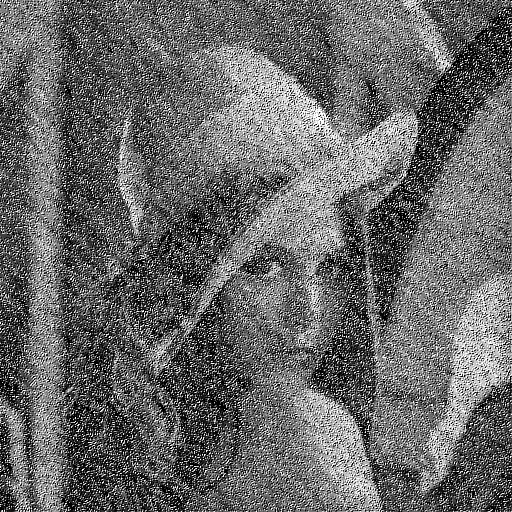

In [ ]:
new_img = noise_removal(img,1.3,2.3,50)
cv2_imshow(new_img)

In [ ]:
psnr(original,new_img)

10.132736337756088

**Algorithm 3**

In [ ]:
def noise_detection(noisy_img, img): 
  N = np.zeros((img.shape[0], img.shape[1]))
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if(noisy_img[i][j] != img[i][j] and (noisy_img[i][j] == 0 or noisy_img[i][j] == 255)):
        N[i][j] = 1

  return N

def find_N(N):
  m = N.shape[0]
  n = N.shape[1]
  l = []
  for i in range(n):
    for j in range(m):
      if(N[i][j] == 1):
        l.append([i,j])

  return l

#find_N(np.array([[0,0,1],[0,1,0],[1,0,0]]))

**Thank You**